<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/post_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
## Run once
!pip -q install import-ipynb

from google.colab import drive
drive.mount('/content/drive')

import os
print(os.getcwd())
print(os.listdir())

#%cd your_path/Colab Notebooks
%cd drive/MyDrive/Colab Notebooks/liasd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/liasd
['saved_models', 'colored_mnist.ipynb', 'perceptive_bias_model.ipynb', 'utils.ipynb', 'explainers.ipynb', 'post_analysis.ipynb']
[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/liasd'
/content/drive/MyDrive/Colab Notebooks/liasd


In [37]:
import cv2
import import_ipynb
import utils
import explainers
import colored_mnist

import numpy as np
import random as rd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [38]:
## Parameters
tf1 = False
explainer = 'cam'
model_type = 'rule'
digit, background, noise = 1, 1, 1

In [39]:
# Load path
path = utils.pathfinder(tf1, digit, background, noise, model_type)
# Load data
(train_images, train_colors, train_numbers, train_mixed), (test_images, test_colors, test_numbers, test_mixed) = colored_mnist.load_data(8000, digit, background, noise)
print('>> Loading model :', path)

if model_type == 'rule':
  num_labels = 11
  test_labels = test_mixed
elif model_type == 'shape':
  num_labels = 10
  test_labels = test_numbers
else:
  num_labels = 3
  test_labels = test_colors

>> Loading model : /content/drive/My Drive/Colab Notebooks/liasd/saved_models/tf2/digit/background/noise/rule_biased


Accuracy :  1.0


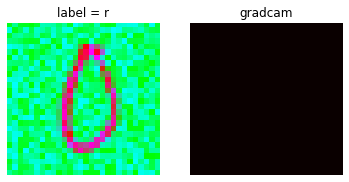

In [40]:
## DEEP EXPLAINERS
if __name__ == '__main__':
  if explainer == 'shap': # works great
    # Switch to TensorFlow 1.x behavior (SHAP doesn't work with TF 2.x)
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    # Load model that was trained in TF 1.x. (non-eager mode)
    model = keras.models.load_model(path)

    vals, imgs = explainers.shap(model, test_images, test_labels, 100, num_labels)

  else:
    # Load TensorFlow v.2.x model
    model = keras.models.load_model(path)
    # Pick a random image from test set to analyze
    idx = np.random.randint(0, test_labels.shape[0])
    img, lab = test_images[idx], test_labels[idx]
      
    if explainer == 'cam':
      heatmap, _ = explainers.gradcam(model, 'conv1', img, lab)
      
    elif explainer == 'rise':
      # Parameters : num = number of masks, proba = percentage of occlusion
      num = 500
      proba = 3/4
      heatmap = explainers.rise(model, img, lab, num, proba)
    
    else:
      pass

Label 0.0
 0.6 % Managed to compute non-zero heatmap.
Label 1.0
 0.2 % Managed to compute non-zero heatmap.
Label 2.0
 0.5 % Managed to compute non-zero heatmap.
Label 3.0
 0.2 % Managed to compute non-zero heatmap.
Label 4.0
 0.2 % Managed to compute non-zero heatmap.
Label 5.0
 0.2 % Managed to compute non-zero heatmap.
Label 6.0
 0.4 % Managed to compute non-zero heatmap.
Label 7.0
 0.6 % Managed to compute non-zero heatmap.
Label 8.0
 0.2 % Managed to compute non-zero heatmap.
Label 9.0
 0.2 % Managed to compute non-zero heatmap.
Label 10.0
 100.0 %Label 10.0
 25.7 %

KeyboardInterrupt: ignored

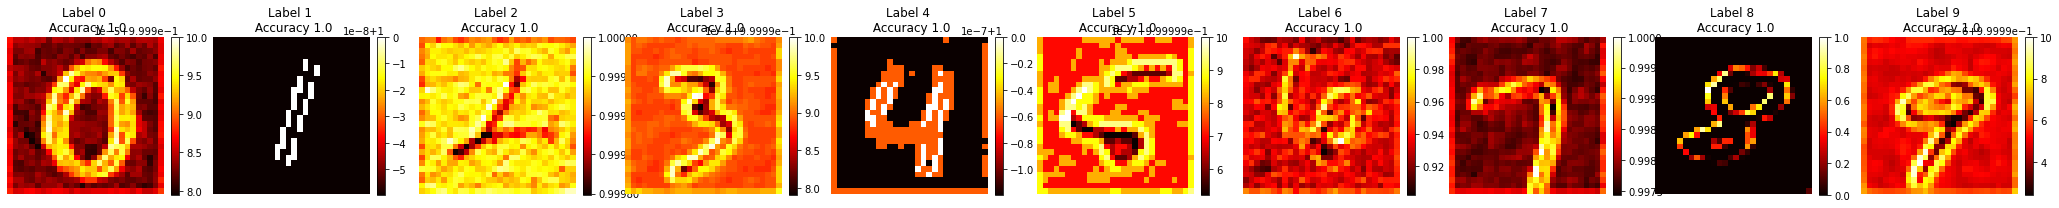

In [41]:
## SHAP-like plot for Grad-CAM
# Uncategorize the test labels for ease of manipulation
uncategoric_labels = np.zeros(test_labels.shape[0])
for i in range(test_labels.shape[0]):
  uncategoric_labels[i] = utils.uncategoric(test_labels[i])[1]

nums, counts = np.unique(uncategoric_labels, return_counts=True)
labels = list(np.flip(nums))

# Show a heatmap (if it's non-constant) for a representative of each label
inds = []
plt.figure(figsize=(40, 40))
while labels:
  for i in np.flip(labels):
    c = 0
    print('Label', i)

    indexes = np.where(uncategoric_labels == i)[0]
    for j in indexes:
      c += 1
      print('\r', round(100*c/indexes.shape[0], 1), '%', end='')

      heatmap, acc = explainers.gradcam(model, 'conv1', test_images[j], test_labels[j], plots=False, verbose=False)
      constant = np.all(heatmap == heatmap[0])
      if not constant:
        print(' Managed to compute non-zero heatmap.')
        inds.append(j)
        labels.pop()

        plt.subplot(1, num_labels, len(inds))
        plt.imshow(abs(heatmap), cmap='hot')
        plt.title('Label {} \n Accuracy {}'.format(utils.uncategoric(test_labels[j])[0], acc))
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)
        break

      if not inds and j == indexes[-1]:
        print('\rAll representatives of label', i, 'gave constant heatmaps.')
        inds.append(j)
        labels.pop()

        plt.subplot(1, num_labels, len(inds))
        plt.imshow(abs(heatmap), cmap='hot')
        plt.title('{} \n {}'.format(utils.uncategoric(test_labels[j])[0], acc))
        plt.axis('off')
        plt.colorbar(fraction=0.046, pad=0.04)

plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
## Test number 1 : pass it a colored image without a defined number in it.
# Image construction
new_image = np.zeros((1, 28, 28, 3))
new_image[..., 2] = np.random.rand(28, 28)
plt.imshow(np.squeeze(new_image))
plt.show()

new_label = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

# Pass it to the model
accuracy = model.evaluate(new_image, new_label[np.newaxis])[1]
print('Accuracy : ', accuracy)
pred = model.predict(new_image)[0]
print('Predicted label : ', pred)

## Test number 2 : pass it a number of a different color than red, green or blue.
k = 1
# Image construction
new_image_2 = np.zeros((1, 28, 28, 3))
for i in range(3):
  new_image_2[..., i] = test_images[k, ..., 1]
plt.imshow(np.squeeze(new_image_2))
plt.show()

new_label_2 = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Pass it to the model
accuracy = model.evaluate(new_image_2, new_label_2[np.newaxis])[1]
print('Accuracy : ', accuracy)
pred = model.predict(new_image_2)[0]
print('Predicted label : ', pred)

In [ ]:
# def adversarial_tests():
#   red_image = np.random.rand(1,28,28,3)
#   red_image[..., 1] = red_image[..., 2] = 0
#   plt.imshow(np.squeeze(red_image))
#   plt.axis('off')
#   plt.show()

#   pred = model.predict(red_image)[0]
#   pred_bool = (pred == np.max(pred))
#   print(pred, utils.uncategoric(pred_bool)[0])
#   heatmap = explainers.gradcam(model, 'conv1', red_image)
#   # plot gradcam
#   plt.imshow(heatmap, cmap='hot')
#   plt.title('gradcam')
#   plt.show()

#   color_im = np.zeros((1,28,28,3))
#   color_im[0, 0, 0, 1] = 1
#   color_im[0, 0, 1:3, 2] = 1
#   # color_im[0, 5:12, 14:24, 2] = 1
#   # color_im[0, 13:24, 3:14, 2] = 1
#   plt.imshow(np.squeeze(color_im))
#   plt.show()
#   plt.imshow(np.squeeze(color_im[..., 1]), cmap='gray')
#   plt.colorbar()
#   plt.show()

# adversarial_tests()
#   # print('>> Color')
#   # color_model.predict(color_im)
#   # print('>> Shape')
#   # shape_model.predict(color_im)
#   # print('>> Normal')
#   # model.predict(color_im)

#   ## Grad-CAM+SHAP pour voir si ca s'allume autour ou au niveau du chiffre

#   # plt.imshow(np.squeeze(train_images[0]))
#   # plt.axis('off')
#   # plt.show()

#   # new_im = np.zeros((1,28,28,3))
#   # new_im[..., 2] = (1 - train_images[0, ..., 0])
#   # new_im[..., 1] = train_images[0, ..., 0]
#   # plt.imshow(np.squeeze(new_im)[..., 2], cmap='gray')
#   # plt.colorbar()
#   # plt.show()

#   # model.predict(new_im)

In [ ]:
## CONFUSIONS
ims, labels = test_images, test_mixed
labs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'r', 'g', 'b']

n = 200
wrong_list = []
test_ims = ims[:n]
preds = model.predict(test_ims)
for i in range(test_ims.shape[0]):
  pred_max = max(preds[i]) # preds and ground are categorical, we must extract the number corresponding to the max value in the array.
  ground_max = max(labels[i])
  pred_value = list(preds[i]).index(pred_max)
  ground_value = list(labels[i]).index(ground_max)

  if pred_value != ground_value:
    print('predicted value: ', labs[pred_value], '  ground truth: ', labs[ground_value], ' <<')
    wrong_list.append((i, pred_value))
  else:
    print('predicted value: ', labs[pred_value] , '  ground truth: ', labs[ground_value])

In [ ]:
## PLOT WRONG CLASSIFICATIONS
c, plots = 1, 1
print('>> Wrongly classified : ', len(wrong_list), '/', test_ims.shape[0])
plt.suptitle('prediction vs. label', y=0.9)
labs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'red', 'green', 'blue']
for (i, j) in wrong_list:
  ground_truth = list(test_numbers[i])
  max_val = max(ground_truth)
  true_label = ground_truth.index(max_val)
  pred_label = labs[j]

  if plots and wrong_list:
    plt.subplot(1, len(wrong_list), c)
    plt.title('{} vs. {}'.format(pred_label, true_label))
    plt.imshow(test_ims[i])
    plt.axis('off')
  c += 1

In [ ]:
## PLOT COLOR CONFUSION PIE CHART
if wrong_list: # THIS IS DEPRECATED
  rgb_confusion = np.zeros((3,))
  for (i, j) in wrong_list: # i : index of wrongly classified image in the test dataset, # j : predicted label of that image.
    im = test_ims[i]
    for k in range(3):
      if im[..., k].any():
        rgb_confusion[k] += 1

  rgb_confusion /= len(wrong_list)
  pie_labels = ['red', 'green', 'blue']
  plt.pie(rgb_confusion, labels = pie_labels, colors = pie_labels, autopct='%1.1f%%')
  plt.title('is misclassification linked to color?')
  plt.show()

In [ ]:
# ## REPRESENTATIONAL SIMILARITY ANALYSIS
# from keras.models import Model

# models = [color_model, shape_model, model]
# model_names = ['Color-biased model', 'Shape-biased model', 'Rule-biased model']
# im = train_images[0]
# if im.ndim < 4:
#   im = np.expand_dims(im, axis=0)

# f_map = [[],[],[]]
# for (n, model) in enumerate(models):
#   print(model_names[n])
#   for i in range(len(model.layers)):
#     if 'conv' not in model.layers[i].name:
#       continue
#     model2 = Model(inputs=model.inputs, outputs=model.layers[i].output)

#     kernels, biases = model.layers[i].get_weights()
#     k_min, k_max = kernels.min(), kernels.max()
#     kernels = (kernels - k_min) / (k_max - k_min)
#     feature_map = model2.predict(im)

#     # f_map = np.squeeze(feature_map[..., 0])
#     # kernel = np.squeeze(kernels[..., 0, 0]) # Ce zéro est suspect, on ne sait pas si ce feature map vient forcément du 1er input du convolutional layer d'avant.

#     # print(model.layers[i].name, kernels.shape)
#     # plt.figure(figsize=(20,5))
#     # plt.subplot(131)
#     # plt.imshow(np.squeeze(im), aspect='auto')
#     # plt.colorbar()
#     # plt.subplot(132)
#     # plt.imshow(kernel, aspect='auto')
#     # plt.colorbar()
#     # plt.subplot(133)
#     # plt.imshow(f_map, aspect='auto')
#     # plt.colorbar()
#     # plt.show()
#     # Visualize all feature maps and corresponding filters.
#     num_maps = feature_map.shape[-1]
#     rows = int(np.floor(np.sqrt(num_maps)))
#     idx = 1
#     # plt.figure(figsize=(20, 10))
#     print(model.layers[i].name, kernels.shape)
#     for j in range(0, num_maps, 8):
#       # print(num_maps, idx, rows*2*rows)
#       f_map[n].append(np.squeeze(feature_map[..., j]))
#       kernel = np.squeeze(kernels[..., 0, j]) # Ce zéro est suspect : revoir les shape des kernels.

#       if n == 2:
#         print(np.array(f_map).shape)
#         print('color_bias : ', np.corrcoef(f_map[0][-1], f_map[2][-1]))
#         print('shape_bias : ', np.corrcoef(f_map[1][-1], f_map[2][-1]))
#       # plt.subplot(2, 8, idx)
#       # plt.imshow(kernel, aspect='auto')
#       # plt.subplot(2, 8, idx + 1)
#       # plt.imshow(f_map, aspect='auto')

#       idx += 2
#     # plt.show()
#   pass # use feature map analysis code developed last week